In [1]:
## Setting up environments
import os
import json
import numpy as np
import pandas as pds
from copy import deepcopy
from random import shuffle, randint, uniform

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

**Note**: networkx and scikit-learn packages are needed in this demonstration

In [2]:
import sys
sys.path.insert(0, './')
from Pareto import *
from basics import *

matplotlib.rcParams['font.family'] = "Sans-serif"
matplotlib.rcParams['font.serif'] = "Arial" # Helvetica
matplotlib.rcParams['font.style'] = "normal"
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['mathtext.fontset'] = "custom"
matplotlib.rcParams['mathtext.rm'] = "Arial"

# The HV and IGD scores
The low-dimensional HV and IGD scores in *Figure 5*, *section 2.4* are calculated and stored in `data/` directory. Scores of Pareto fronts in the categories of defect formation energies, rare events (REs), and elastic constants (EC) are calculated as demonstration here.

In [3]:
category = 'Ef'
score = 'hv'
data = pds.read_csv('data/Fig5/{}-{}.csv'.format(category, score)).drop(columns=['Unnamed: 0'])
data.head()

,Keys,GAP,DPMD,SNAP,MTP,NNP,DPPT
0,hex_Ef|spl_Ef,7.165541,4.437930,8.298637,6.171922,3.170248,7.285778
1,hex_Ef|tet_Ef,6.265721,4.780279,8.664641,5.388619,3.737201,5.276983
2,hex_Ef|vac_Ef,9.466158,2.603358,10.451016,5.935090,6.518023,6.723769
3,spl_Ef|tet_Ef,6.398637,4.375166,7.474866,5.755802,3.117175,3.693390
4,spl_Ef|vac_Ef,7.843950,4.587754,7.748029,4.668167,2.326323,7.789292


In [4]:
"""
    Get the scores of different types of models.
    One score for each type of model and each pair of properties (each Pareto front).
    Note that the final row is the scores of high-dimensional Pareto fronts considering all properties (> 2D)
"""
modellist = [n for n in data.keys() if n!='Keys']
top = {}
for m in modellist:
    top[m] = [0, 0] ## The number of the lowest and the second lowest scores

## Take the type of model who has the lowest and the 2nd lowest scores
model_matrix = [[n for n in data[k][:-1]] for k in modellist] ## Exclude the final row
score_matrix = np.transpose(model_matrix)
for scores in score_matrix:
    ## The order of original scores follows the list of model types
    original_scores = [n for n in scores]
    
    ## Use sorted scores to find the lowest and the second lowest scores
    sorted_scores = sorted([n for n in scores])
    
    ## Use the indices of the lowest and the second lowest scores to find the model type
    lowest_index = original_scores.index(sorted_scores[0])
    sec_lowest_index = original_scores.index(sorted_scores[1])
    
    ## Count how many lowest & second lowest scores do each type of model get
    top[modellist[lowest_index]][0]+=1
    top[modellist[sec_lowest_index]][1]+=1

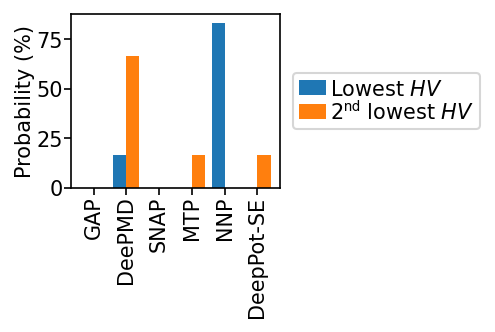

In [5]:
xs = [n for n in range(len(modellist))]
total_front_num = len(data['Keys'])-1
width = 0.4

fig = plt.figure(figsize=(1.8, 1.5), dpi=150)
ax = plt.subplot(1, 1, 1)
y1 = [100*top[k][0]/total_front_num for k in modellist]
y2 = [100*top[k][1]/total_front_num for k in modellist]
ax.bar([x-width/2 for x in xs], y1, width=width, color='tab:blue',
       label='Lowest'+' ${}$'.format(score.upper()))
ax.bar([x+width/2 for x in xs], y2, width=width, color='tab:orange',
       label='2$^{\mathrm{nd}}$ lowest'+' ${}$'.format(score.upper()))

ax.set_ylabel('Probability (%)', fontsize=10, labelpad=0.5)
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
ax.set_xticks(xs)
ax.set_xticklabels([[n for n in model_label_csv.loc[model_label_csv['Models']==k]['label']][0] for k in modellist],
                   fontsize=10, rotation=90)
lgd = plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=10, ncol=1,
                 columnspacing=0.4, handlelength=1.3, borderpad=0.3, labelspacing=0,
                 handletextpad=0.2)
plt.show()
plt.clf()
plt.close()

# Clustering optimal MLIP models in high-dimensional space
&emsp; In this section, we will reproduce the process of clustering optimal MLIP models in high-dimensional (high-$D$) space like the *Figure 5* in *section 2.4*. All calculated data, such as the calculated optimal MLIP models for $E_{\mathrm{f}}^{\mathrm{Defect}}$ and $\mathrm{RE}$s categories and their similarities will be stored in `data/` directory. However, necessary steps to reproduce these data will be demonstrated too.  
  
**Outline**  
1. <u>Obtain the optimal models</u>  
&emsp; First, we select a category of properties, calculate its high-$D$ Pareto fronts for each type of models considering all properties in the category. Then, we calculate the similarities between each two optimal models. The list of optimal models and their error metrics for all properties in the category will be included in `data/` directory.  
&emsp; **Note**: all error metrics are normalized log errors to calculate similarities.  
&emsp; Finally, we will calculate the similarities between each two optimal models and put the result to `data/` directory.  
2. <u>Cluster the optimal models</u>  
   &emsp; We use Louvain community detection algorithm to cluster optimal models, which employs similarities between optimal models as weights of model relationships. The clustering scheme follows *Figure 5* in *section 2.4* of the main text and the clustering results are in `data/` directory.  
   &emsp; Here, the clustered optimal models imply that these models have similar accuracies on predicted properties, but don't imply whether the predictions are good or not. Scattered optimal models indicate that their performances vary. Therefore, the clustering results need to be understood with the evaluation of Pareto fronts using HV and IGD scores in the previous section to have a complete understanding of the joint performance of MLIPs in high-$D$ space.  
   &emsp; This 2-step evaluation (calculate scores of low-$D$ Pareto front and then cluster the optimal models in high-$D$ space) is adopted because of the technical difficulty to directly measure scores of Pareto fronts in high-$D$ space. For instance, the HV scores are very costly to compute if the dimension goes up to around 10 or 20 (like the properties in elastic constant category). This 2-step evaluation strategy is a good approximation and an alternative of spending hours on calculating HV scores of high-$D$ Pareto fronts.  
3. <u>Explain the clustering result</u>  
   &emsp; Here we try to use Lasso models to explain the clustering results following the approach in *explain the clustering results* section in Supporting Information. We fit a Lasso model to classify the optimal models in a selected community. As a linear model, the coefficients of features in Lasso model indicate how important these features are. Therefore these coefficients can be used to explain why the optimal models are in the selected community (whether they're in the community because they have large or small errors on some properties).

### 1. .Obtain the optimal models
Demonstrating the process of constructing high-dimensional Pareto fronts, computing optimal models, and calculating the similarities of optimal models.

In [6]:
def vdist(v1, v2):
    ## Compute the distances between two vectors
    return np.sqrt(sum([(m-n)**2 for m, n in zip(v1, v2)]))

In [7]:
modellist = [n for n in model_label_csv['Models']]
norm_log_data = pds.read_csv('data/normalized_log_errors.csv').drop(columns=['Unnamed: 0'])
norm_log_data.head()

,Models,ModelName,SelectionType,TrainingData,hex_Ef,spl_Ef,tet_Ef,vac_Ef,spl_c11,spl_c12,...,Vacancy_enhanced_E,Vacancy_enhanced_F,Vacancy_RE_E,Vacancy_RE_F,bulk_free_energy,bulk_entropy,bulk_heat_capacity,vacancy_free_energy,vacancy_entropy,vacancy_heat_capacity
0,DFT,Threshold,NaN,NaN,0.504750,0.855112,-0.060705,-0.280528,-0.953033,-0.778269,...,0.236210,-0.761779,0.988656,-1.160869,-0.901101,-1.023010,-0.904197,0.029467,0.226656,0.411471
1,GAP,183-3,s,Org,0.780239,0.611954,0.804912,-1.120803,-0.288999,-0.790659,...,-1.175896,-1.307301,-0.480432,-1.149233,-1.401489,-1.171511,-1.077526,-1.658051,-1.715457,-0.614198
2,GAP,189-5,s,Org,0.850402,0.600587,0.770690,-1.107595,-0.271309,-0.618390,...,-1.219224,-1.348496,-0.524035,-1.198054,-0.922067,-0.831668,-0.992529,-1.102494,-0.823288,-0.556851
3,GAP,341-5,r,Org,0.523894,0.261400,0.071620,-0.302134,-0.177400,-0.673296,...,-0.721812,-0.769159,-0.099455,-0.823599,-1.760735,-1.822453,-0.888281,0.020416,0.173741,0.247983
4,GAP,58-2,r,Org,-0.112582,0.305990,0.316971,-0.145629,-0.351548,-0.823457,...,-0.909181,-1.040954,-0.194338,-0.850400,-1.379172,-1.105195,-0.913820,-1.769730,-1.191872,-0.632313


In [8]:
"""
    1.1 Use the category of defect formation energy as a demonstration
    If using the other categories, the method of selecting properties in the category should be tailored.
    Details of property strings are in Notebook 01 introduction.
"""
category = 'Ef' ## the selected category

## Select properties in the target category
properties = [n for n in norm_log_data.keys() if category in n]

## Create a dictionary of optimal models for each type of MLIP
output = {'Models': [], 'ModelName': [], 'Train': []}
for key in properties:
    output[key] = []

## For each type of MLIP
for m in modellist:
    tmpdf = norm_log_data.loc[norm_log_data['Models']==m]
    property_matrix = [[n for n in tmpdf[k]] for k in properties]
    model_matrix = np.transpose(property_matrix)

    ## the function returns a list of False and True to specify optimal models
    ## 1 corresponds to optimal models
    optimal_model = is_pareto_efficient(model_matrix)
    print(m, '\t', optimal_model[:10])
    for opt, pmat, mn, td in zip(optimal_model, model_matrix,
                                 [n for n in tmpdf['ModelName']],
                                 [n for n in tmpdf['TrainingData']]):
        if opt: ## if the model is an optimal model on Pareto front
            output['Models'].append(m)
            output['ModelName'].append(mn)
            output['Train'].append(td)
            for k, p in zip(properties, pmat):
                output[k].append(p)

GAP 	 [False False False  True False False False False False False]
NNP 	 [False False False False False False False False False False]
DPMD 	 [False False False False False False False False False False]
DPPT 	 [ True False False False False False  True  True False  True]
MTP 	 [False False False False False False False  True False False]
SNAP 	 [ True False  True  True  True  True False  True False False]


In [9]:
outdf = pds.DataFrame(output)
outdf.to_csv('data/Fig5/{}_optimal_demo.csv'.format(category))

In [9]:
"""
    1.2 Calculate the similarities of optimal models
"""
optimal_model_data = pds.read_csv('data/Fig5/{}_optimal.csv'.format(category)).drop(columns=['Unnamed: 0'])
keys = [n for n in optimal_model_data.keys()]
optimal_model_data.head()

,Models,ModelName,Train,hex_Ef,spl_Ef,tet_Ef,vac_Ef
0,GAP,58-2,Org,-0.112582,0.305990,0.316971,-0.145629
1,GAP,53-4,Org,-0.275911,-0.032638,-0.641192,0.315035
2,GAP,383-1,Org,0.616060,0.702720,0.820050,-1.841054
3,GAP,376-1,Org,0.762788,0.580973,0.811659,-2.043911
4,GAP,166-2,Org,0.124416,0.383649,0.292448,-0.724111


In [10]:
"""
    X: optimal model 1
    Y: optimal model 2
    1/d: the similarity between model 1 and model 2
"""
similarities = {'X': [], 'Y': [], '1/d': []}
property_matrix = [[n for n in optimal_model_data[k]] for k in keys]
model_matrix = np.transpose(property_matrix)
for ix, x in enumerate(model_matrix[:-1]):
    for y in model_matrix[ix+1:]:
        ## The first three elements are MLIP type, model name, and training dataset
        xn = '|'.join([x[1], x[0], x[2]])
        yn = '|'.join([y[1], y[0], y[2]])
        xv = [float(n) for n in x[3:]]
        yv = [float(n) for n in y[3:]]
        similarities['X'].append(xn)
        similarities['Y'].append(yn)
        similarities['1/d'].append(1/vdist(xv, yv))

In [24]:
similaritydf = pds.DataFrame(similarities)
similaritydf.to_csv('data/Fig5/{}_similarities_demo.csv'.format(category))

### 2. Cluster the optimal models  
  
&emsp; To clearly separate optimal models having similar performances, we set a similarity cut-off to construct graphs of models. We adopted the following steps to pick the best similarity cut-off,  

 - To conduct a grid search and pick the best similarity cut-off, we set a range and perform Louvain clustering for each of the cut-off values in the range (evenly spaced on logrithm scale).  
 - We compare all clustering results with the labels of MLIP types and calculate the adjusted random score (ARS), or adjusted random index.
 - We then pick the clustering result with the highest ARS and use that similarity value as cut-off.  
  
&emsp; **Note**: To run this section of the notebook, we'll need the networkx package and its Louvain community detection algorithm for clustering.

In [11]:
## networkx setup
import networkx as nx
from networkx.algorithms.community import louvain_communities

In [12]:
## sklearn setup
import sklearn
from sklearn.metrics import adjusted_rand_score

def get_predicted_label(nodelist, communities):
    nodep = []
    for nl in nodelist:
        found = 0
        for i, subc in enumerate(communities):
            if nl in subc:
                nodep.append(i)
                found = 1
                break
        if not found:
            raise ValueError('{} not found!'.format(nl))
    return nodep

In [13]:
colordict = {}
for m, n in zip(model_label_csv['Models'], model_label_csv['Color']):
    colordict[m] = n

In [14]:
## Load the data of optimal models
category = 'Ef'

opt_model_data = pds.read_csv('data/Fig5/{}_optimal.csv'.format(category)).drop(columns=['Unnamed: 0'])

## Set the node representation of optimal model graphs
## the node representation should fit the representation of optimal models in similarity csv
total_nodes = ['|'.join([n, m, l]) for m, n, l in zip(opt_model_data['Models'],
                                                      opt_model_data['ModelName'],
                                                      opt_model_data['Train'])]
total_colors = [colordict[n.split('|')[1]] for n in total_nodes]
print(total_nodes[0])
opt_model_data.head()

58-2|GAP|Org


,Models,ModelName,Train,hex_Ef,spl_Ef,tet_Ef,vac_Ef
0,GAP,58-2,Org,-0.112582,0.305990,0.316971,-0.145629
1,GAP,53-4,Org,-0.275911,-0.032638,-0.641192,0.315035
2,GAP,383-1,Org,0.616060,0.702720,0.820050,-1.841054
3,GAP,376-1,Org,0.762788,0.580973,0.811659,-2.043911
4,GAP,166-2,Org,0.124416,0.383649,0.292448,-0.724111


In [15]:
## Load the similarity data of optimal models from previous calculations
opt_sim_data = pds.read_csv('data/Fig5/{}_similarities.csv'.format(category)).drop(columns=['Unnamed: 0'])
opt_sim_data.head()

,X,Y,1/d
0,58-2|GAP|Org,53-4|GAP|Org,0.886787
1,58-2|GAP|Org,383-1|GAP|Org,0.511921
2,58-2|GAP|Org,376-1|GAP|Org,0.461753
3,58-2|GAP|Org,166-2|GAP|Org,1.586220
4,58-2|GAP|Org,29-1|GAP|Org,0.444515


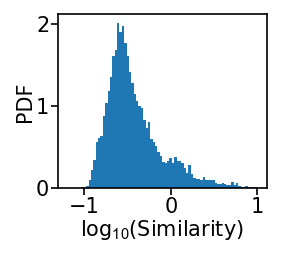

In [16]:
## Set the range searching for the best similarity cut-off
total_num = 81
sim_log = [np.log10(n) for n in opt_sim_data['1/d']]
minlog = round(min(sim_log), 1)-0.2
maxlog = np.ceil(round(np.mean(sim_log)+0.5, 1))

## Plot the probability density function (PDF)
fig = plt.figure(figsize=(1.8, 1.5), dpi=150)
ax = plt.subplot(1, 1, 1)
ax.hist(sim_log, bins=np.linspace(minlog, maxlog, total_num), density=True)
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
ax.set_ylabel('PDF', fontsize=10, labelpad=0.5)
ax.set_xlabel(r'log$_\mathrm{10}$(Similarity)', fontsize=10, labelpad=0.5)
plt.show()
plt.clf()
plt.close()

In [17]:
"""
    2.1 Construct the similarity graph of different models
"""
## Create a graph with nodes only
## Each node represents an optimal model
empty = nx.Graph()
empty.add_nodes_from(total_nodes, color=total_colors)

nodelist = deepcopy([n for n in empty.nodes])
nodelabels = [n.split('|')[1] for n in empty.nodes]

In [21]:
## Get clustering results and ARS with different cutoffs
cutoffs = np.logspace(minlog, maxlog, total_num)

r_communities = []
arss = []

## Iterating over different cut-offs
## This may take a while if the graph is large and there are many cut-off values
for cf in cutoffs:
    tmp_graph = nx.create_empty_copy(empty)
    for x, y, sim in zip(opt_sim_data['X'], opt_sim_data['Y'], opt_sim_data['1/d']):
        if sim>cf:
            tmp_graph.add_edge(x, y, sim=sim, log=np.log10(sim))

    ## the clustering step using Louvain method
    communities = louvain_communities(tmp_graph, weight='sim')
    r_communities.append(deepcopy(communities))

    nodepred = get_predicted_label(nodelist, communities)
    ari = adjusted_rand_score(nodelabels, nodepred)
    arss.append(ari)

"""
    2.2 Obtain the best similarity cut-off with the highest ARS
"""
max_index = arss.index(max(arss))
print('Cut-off:', round(cutoffs[max_index], 1))
print('ARS:', round(arss[max_index], 1))

Cut-off: 1.4
ARS: 0.5


**Note**: the ARS line and the best similarity cut-off may differ each time you run because Louvain method is heuristic in nature and thus is randomized if the iteration numbers are not large. It may also occasionally produce arbitrarily badly connected clusters. For similarity cut-offs of $E_{\mathrm{f}}^{\mathrm{Defect}}$ and $RE$s categories in *Figure 5 section 2.4*, they usually fall in the range between 1.3 and 1.4 (but in rare occasions may go down to 1.0 or up to 1.6).

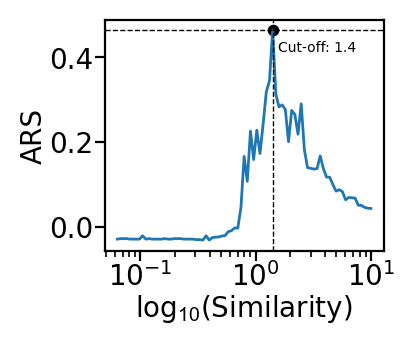

In [22]:
fig = plt.figure(figsize=(1.8, 1.5), dpi=200)
ax = plt.subplot(1, 1, 1)

ax.plot(cutoffs, arss, linewidth=1)
## Label the best similarity cut-off
ax.scatter([cutoffs[max_index]], [arss[max_index]], s=10, color='black')
ax.annotate('Cut-off: {}'.format(round(cutoffs[max_index], 1)),
            (cutoffs[max_index]+2, arss[max_index]-0.05),
            color='black', fontsize=5, ha='center')
ax.axvline(x=cutoffs[max_index], linewidth=0.5, linestyle='dashed', color='black')
ax.axhline(y=arss[max_index], linewidth=0.5, linestyle='dashed', color='black')
ax.semilogx()

plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
ax.set_xlabel(r'log$_\mathrm{10}$(Similarity)', fontsize=10, labelpad=0.5)
ax.set_ylabel('ARS', fontsize=10, labelpad=0.5)
plt.show()
plt.clf()
plt.close()

Show the clustering result of major communities ($N_{\mathrm{model}}$ > 10)

In [23]:
"""
    2.3 Obtain the clustering result with the best similarity cut-off (the highest ARS)
"""
print('Cut-off index:', max_index)
print('\n')
for ir, r in enumerate(r_communities[max_index]):
    if len(r)>10:
        check = [n.split('|')[1] for n in r]
        print('Community index: {};\nsize: {}\nDistribution'.format(ir, len(r)), '-')
        for c in set(check):
            print('\t{}'.format(c), len([n for n in check if n==c]))
r_community = deepcopy(r_communities[max_index])

Cut-off index: 49


Community index: 5;
size: 41
Distribution -
	GAP 41
Community index: 75;
size: 16
Distribution -
	DPPT 16
Community index: 80;
size: 18
Distribution -
	DPPT 16
	DPMD 2
Community index: 110;
size: 91
Distribution -
	SNAP 90
	GAP 1


In [24]:
## Get the final clustered graph
result = nx.create_empty_copy(empty)
for x, y, sim in zip(opt_sim_data['X'], opt_sim_data['Y'], opt_sim_data['1/d']):
    if sim>cutoffs[max_index]:
        result.add_edge(x, y, sim=sim)

## Get the color of each node
node_color=[colordict[n.split('|')[1]] for n in result.nodes]

## 'neato' is a good choice of graph representation
## Note: the x and y coordinates of nodes here don't have physical meaning!!!
pos = nx.nx_agraph.graphviz_layout(result, prog="neato", args="-Gmaxiter=100")
check = {}
for n, c in zip(result.nodes, node_color):
    nm = n.split('|')[1]
    if nm in check.keys():
        if check[nm]!=c:
            raise ValueError('Wrong color!')
    else:
        check[nm]=c

/Users/yunshengliu/miniconda3/envs/intf/lib/python3.9/site-packages/pygraphviz/agraph.py:1407: RuntimeWarning: Warning: ['tab is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


**Note**: 'neato' algorithm may randomly generate coordinates of nodes, so the figure may not look exactly the same with the *Figure 5* in *section 2.4*. Nonetheless, the communities (printed above) are the same and you can identify them if looking closely :-)

X: 69 1669
Y: 18 1602


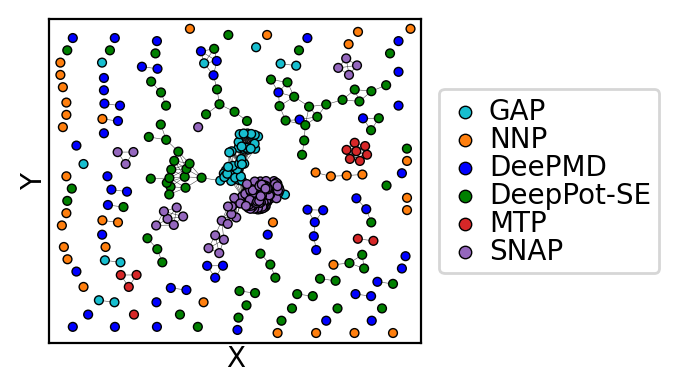

In [25]:
fig = plt.figure(figsize=(2.4, 2.1), dpi=200)
ax = plt.subplot(1, 1, 1)

## Draw nodes only
nx.draw_networkx_nodes(empty, pos=pos, node_color=node_color, node_size=10, linewidths=0.5,
                       edgecolors='black', alpha=1)
pos_data = [pos[k] for k in pos.keys()]
print('X:', round(min([n[0] for n in pos_data])), round(max([n[0] for n in pos_data])))
print('Y:', round(min([n[1] for n in pos_data])), round(max([n[1] for n in pos_data])))

## Draw edges only
nx.draw_networkx_edges(result, pos=pos, width=0.2, alpha=0.7)
ax.set_xlabel('X', fontsize=10, labelpad=0.5)
ax.set_ylabel('Y', fontsize=10, labelpad=0.5)

## Legend only
space = 50
xs = [n[0] for n in pos_data]
ys = [n[1] for n in pos_data]
ax.set_xlim(round(min(xs))-space, round(max(xs))+space)
ax.set_ylim(round(min(ys))-space, round(max(ys))+space)
for m in check.keys():
    tmpdf = model_label_csv.loc[model_label_csv['Models']==m]
    mlabel = [n for n in tmpdf['label']][0]
    ax.scatter([round(min(xs))-2*space], [round(min(ys))-2*space], marker='o', s=20,
               color=colordict[m], linewidth=0.5, edgecolor='black', label=mlabel)
lgd = plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=10, ncol=1,
                 columnspacing=0.4, handlelength=1.3, borderpad=0.3, labelspacing=0,
                 handletextpad=0.2)
plt.show()
plt.clf()
plt.close()

### 3. Explain the clustering result
&emsp; In this section, we explain the clustering result using logistic regression model, a generalized linear model. This approach is generally a **global surrogate** method in [interpretable machine learning](https://christophm.github.io/interpretable-ml-book/global.html#global). It's an approach particularly good at explaining classification results. Here, we have many major communities identified by Louvain algorithm and we want to know why these optimal models are clustered together. Or to say, we want to know if these optimal models perform similarly good or bad on some properties so that they are clustered. The logistic regression explanation is directly conducted in high-$D$ space and the final explanations should closely match the low-$D$ scores of Pareto fronts.  
&emsp; For instance, the logistic regression explanation of a selected community of optimal models suggests that they're in the cluster because they have low errors on some properties (in which case the properties have negative feature coefficients). We should also observe that low-$D$ Pareto fronts of these optimal models have lower HV and IGD scores than other models, which suggests that these optimal models perform well on the selected properties. Then the observations of low-$D$ Pareto front scores fit the high-$D$ logistic regression explanation.  
&emsp; Our 2-step approach of evaluating optimal models in high-$D$ space is generally verified by this explanation method (in Supporting Information) in the $E_{\mathrm{f}}^{\mathrm{Defect}}$ and $\mathrm{RE}$s categories.

In [26]:
"""
    Community interpretation
"""
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
from sklearn.linear_model import LogisticRegression ## here we use logistic regression as base estimator

def generate_labels(community, nodelist):
    """
        Customized code to select a community and label all nodes in the community as 1,
        and leave all nodes outside the community as 0.
    """
    tmp = []
    for nd in nodelist:
        if nd in community:
            tmp.append(1)
        else:
            tmp.append(0)
    return tmp

def GridCV(X, Y, estimator, grid):
    """
        Function to search for the best hyper-parameter
        X: data input
        Y: data output
        estimator: simple explainable models like generalized linear models and decision trees
        grid: a dictionary of hyper-parameters with their searched values

        Here, the cross-validation strategy is fixed to be split into 10 fold and repeated for 3 times 
    """
    est = deepcopy(estimator) ## base estimator

    ## The cross-validation strategy here is to split into 10 fold
    ## and repeat for 3 times
    ## This can be tailored if needed
    cv = RepeatedKFold(n_splits=10, n_repeats=3)
    search = GridSearchCV(estimator, grid, scoring='neg_mean_absolute_error', cv=cv,
                          n_jobs=-1)
    results = search.fit(X, Y)
    return results.best_params_

In [27]:
"""
    Get the X property input data using the order of nodes in graphs
"""
modelkeys = ['ModelName', 'Models', 'TrainingData']
propertykeys = [n for n in norm_log_data.keys() if category in n]

Here, we need the <u>normalized log errors</u> to fit logistic regression models. However, we need the <u>absolute errors</u> to explain the clustering results. The logistic regression results (the probabilities to be in a cluster/community) can be directly applied on <u>absolute errors</u> because the normalized $\mathrm{log}_{\mathrm{10}}(\mathrm{errors})$ don't change monotonicity compared with <u>absolute errors</u>.

In [28]:
absolute_data = pds.read_csv('data/absolute_errors.csv').drop(columns=['Unnamed: 0'])
absolute_data.head()

,Models,ModelName,SelectionType,TrainingData,hex_Ef,spl_Ef,tet_Ef,vac_Ef,spl_c11,spl_c12,...,Vacancy_enhanced_E,Vacancy_enhanced_F,Vacancy_RE_E,Vacancy_RE_F,bulk_free_energy,bulk_entropy,bulk_heat_capacity,vacancy_free_energy,vacancy_entropy,vacancy_heat_capacity
0,DFT,Threshold,NaN,NaN,1.314134,1.243361,0.941977,0.581713,3.176210,4.868190,...,15.000000,0.120000,15.000000,0.173772,0.252635,0.331579,0.114606,39.090915,91.621454,41.022815
1,GAP,183-3,s,Org,1.731683,0.991808,2.008824,0.278863,25.680561,4.682056,...,4.778721,0.092487,5.487769,0.174605,0.117751,0.261441,0.084660,3.302113,4.398669,6.657992
2,GAP,189-5,s,Org,1.857748,0.981382,1.949569,0.282105,27.150928,8.050820,...,4.613906,0.090686,5.326408,0.171139,0.244683,0.450378,0.098215,7.449613,17.745796,7.370485
3,GAP,341-5,r,Org,1.339574,0.715976,1.057594,0.570819,36.488201,6.773480,...,6.903331,0.119578,7.122682,0.199590,0.068068,0.092246,0.117838,38.576201,84.346695,30.701047
4,GAP,58-2,r,Org,0.708142,0.746278,1.310819,0.654595,21.091292,4.222978,...,5.931192,0.105027,6.674811,0.197406,0.121829,0.290714,0.112695,2.803903,9.973107,6.447567


In [29]:
"""
    Get the X property input data following the order of model nodes in graphs
    Both absolute and normalized log errors need to be prepared:
        - absolute errors are to explain the clusters
        - normalized log errors are to fit the logistic regression of explanations
"""
X_log = []
X_abs = []
for nd in result.nodes:
    r = nd.split('|')
    ndf = norm_log_data.loc[(norm_log_data[modelkeys[0]]==r[0]) & (norm_log_data[modelkeys[1]]==r[1]) & \
                            (norm_log_data[modelkeys[2]]==r[2])]
    adf = absolute_data.loc[(absolute_data[modelkeys[0]]==r[0]) & (absolute_data[modelkeys[1]]==r[1]) & \
                            (absolute_data[modelkeys[2]]==r[2])]
    if len(ndf['Models'])!=1:
        print(ndf)
        raise ValueError('Wrong query: {}'.format(r))
    X_log.append(deepcopy([[n for n in ndf[m]][0] for m in propertykeys]))
    X_abs.append(deepcopy([[n for n in adf[m]][0] for m in propertykeys]))
print(np.shape(X_log), np.shape(X_abs))

(360, 4) (360, 4)


In [30]:
"""
    Pre-process of property input data (X) and cluster labels (Y)
     - select the hyper-parameter to fit logistic regression model
    
    Here we try to explain multiple communities
    If we want to explain a single community in clustering result,
    just put 1 index of that selected community.
"""
## cluster indices from previous clustering result of detected communities
c_indices = [5] 

## To get a stable explanation (feature coefficients)
## we randomly select 2/3 of all data (X property input and Y cluster labels) for 20 times
kfold = 20

community = set([n for ci in c_indices for n in r_community[ci]])
Y_data = generate_labels(community, nodelist)
model = LogisticRegression(penalty='l1', solver='saga', max_iter=10000)
grid = {'C': np.logspace(-1, 1, 26)}
## we use the function defined above to select the best hyper-parameter
params = GridCV(X_log, Y_data, model, grid)

In [31]:
"""
    Calculate the feature importances, or coefficients of properties (X features)
"""
coefs_ = []
models = []
for kf in range(kfold):
    ## logistic regression model with the selected hyper-parameter C
    lr = LogisticRegression(penalty='l1', C=params['C'], solver='saga', max_iter=10000)
    ## Take 2/3 of all data to fit a logistic regression model each time
    X_train, X_test, y_train, y_test = train_test_split(X_log, Y_data, test_size=0.33)
    lr.fit(X_train, y_train)
    lr_test = deepcopy([n for n in lr.coef_[0]])

    ## Uncomment the following line if you want all coefficients to be normalized
    # lr_test /= np.max(lr_test)
    
    score = lr.score(X_train, y_train)
    ## Convenient: we append the score of model to the coefficients
    ## This enables us to find the best set of model coefficents fast
    lr_test.append(score) ## R2 score
    ## Coefficients of input properties,
    ## or feature importance for explanation
    coefs_.append(deepcopy(lr_test)) 
    models.append(deepcopy(lr))
print(np.shape(coefs_))

(20, 5)


In [32]:
"""
    Post-process of taking the average of coefficients
"""
tp_coefs = np.transpose(coefs_)
## the last element is the R2 score we appended
ys = [np.mean(n) for n in tp_coefs[:-1]]
y_max = [max(n) for n in tp_coefs[:-1]]
y_min = [min(n) for n in tp_coefs[:-1]]

# Get the property key labels
keylabels = []
for k in propertykeys:
    tmpdf = property_label_csv.loc[property_label_csv['Properties']==k]
    kls = [n for n in tmpdf['label']]
    keylabels.append(kls[0])

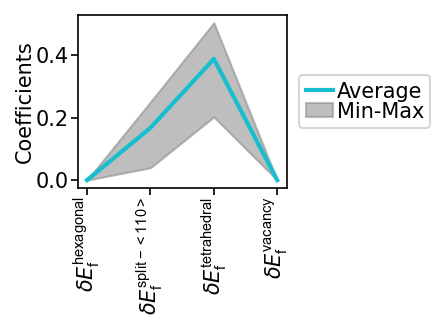

In [33]:
## The model is obtained from the community information above
community_model = 'GAP'
fig = plt.figure(figsize=(1.8, 1.5), dpi=150)
ax = plt.subplot(1, 1, 1)

ax.plot(range(len(ys)), ys, color=colordict[community_model], linewidth=2, label='Average')
ax.fill_between(range(len(ys)), y_min, y_max, color='tab:grey', alpha=0.5, label='Min-Max')
ax.set_ylabel('Coefficients', fontsize=10, labelpad=0.5)

## Figure format
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
ax.set_xticks([n for n in range(len(propertykeys))])
ax.set_xticklabels(keylabels, fontsize=10, rotation=90)
lgd = plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=10,
                 columnspacing=0.4, handlelength=1.3, borderpad=0.3, labelspacing=0,
                 handletextpad=0.2)
plt.show()
plt.clf()
plt.close()

The coefficient figure here follows the scheme in *Supplementary Figure S6*.
- Positive coefficients correspond to worse performance: the larger the errors are, the more likely the model show up in the community  
- Negative coefficients correspond to better performance: the smaller the errors are, the more likely the model are to be in the community  

In [34]:
"""
    Scatter the error metric (in absolute value) of property vs. prediction probability
"""
property_index = 2
## Here we use the R2 score we appended above to find the best property coefficient
## The R2 score is the final element of coefficient matrix
modelindex = [n for n in tp_coefs[-1]].index(max(tp_coefs[-1]))

## Select the best logistic regression model
## Get the predicted probabilities
best_lr = models[modelindex]
ys_cs = best_lr.predict_proba(X_log)
ys_pb = [n[1] for n in ys_cs]
xs_val = [m[2] for m, n in zip(X_abs, X_log)]
print(np.shape(xs_val), np.shape(ys_pb))

(360,) (360,)


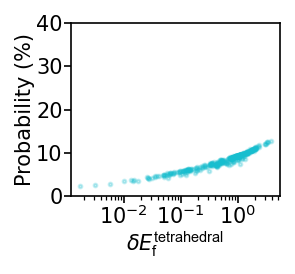

In [35]:
fig = plt.figure(figsize=(1.8, 1.5), dpi=150)
ax = plt.subplot(1, 1, 1)
ax.scatter(xs_val, [100*n for n in ys_pb], s=3, alpha=0.25, color=colordict[community_model])
ax.semilogx()

ax.set_xlabel(keylabels[property_index], fontsize=10, labelpad=0.5)
ax.set_ylabel('Probability (%)', fontsize=10, labelpad=0.5)

## Figure format
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
ax.set_yticks([0, 10, 20, 30, 40])

plt.show()
plt.clf()
plt.close()

We did it! The coefficient is positive, suggesting that the larger errors are, the more likely the MLIP model is to be in the community. The trend of property values vs. predicted probabilities fits the explanation!  
The figure here follows the scheme in *Supplementary Figure S6* in Supporting Information.